In [1]:
%load_ext autoreload
%autoreload 2

import sys, os, ebf
import numpy as np, pandas as pd

import warnings
warnings.filterwarnings("ignore", message="numpy.dtype size changed")


%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib.pyplot import NullFormatter
import matplotlib
from matplotlib.colors import LogNorm
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 30}
matplotlib.rc('font', **font)

import seaborn as sns
rc={'font.size': 16, 'axes.labelsize': 16, 'legend.fontsize': 12,
    'axes.titlesize': 18, 'xtick.labelsize': 12, 'ytick.labelsize': 12}
sns.set(font="serif",style="white",rc=rc)

In [2]:
folder = '/home/andy/Documents/Research/SF/SFdata/Galaxia_data/'
iso_folder = '/home/andy/Documents/Research/SF/SFdata/'

# Running selection function

In [3]:
sys.path.append('/home/andy/Documents/Research/SF/GitRepo/seestar/')
import SelectionGrid, IsochroneScaling

In [7]:
from seestar import SelectionGrid, IsochroneScaling

## Generate selection function from scratch

We have prebuilt the 3 component GMM selection functions so only use gen_obsSF() if you wish to rebuild (takes about 20' on 3 cores).

gen_intSF() takes less than a minute so this is fine.

In [102]:
survey = pd.read_csv(folder + '/Galaxia_sf_survey.csv')
survey['Colour'] = survey.Japp-survey.Kapp

pointings = pd.read_csv(folder + '/Galaxia_sf_fieldinfo.csv')
pointings = pointings[['fieldID', 'glon', 'glat', 'halfangle','Magmin', 'Magmax', 'Colmin', 'Colmax']]
pointings.rename({'glon':'phi', 'glat':'theta'})

def get_spectro(field):
    
    field_data = survey[survey.fieldID==field]
    field_data = np.array(field_data[['Happ', 'Colour']])
    
    return field_data

def get_photo(field):
    
    file_path = folder + '/photometric/'+str(field)+'.csv'
    field_data = pd.read_csv(file_path, usecols=['Japp', 'Happ', 'Kapp'])
    
    field_data['Colour'] = field_data.Japp - field_data.Kapp
    field_data = np.array(field_data[['Happ', 'Colour']])
    
    return field_data

In [103]:
pointings = pointings[1:]

In [104]:
pointings.Magmin = 'NoLimit'
pointings.Magmax = 'NoLimit'
pointings.Colmin = 'NoLimit'

In [105]:
SF = SelectionGrid.SFGenerator(get_spectro, get_photo, pointings, 
                              spectro_model=('BGM_TNC', None), photo_model=('BGM_TNC', None))

The spectro model description is:('BGM_TNC', None)
The photo model description is:('BGM_TNC', None)


## Generate new selection functions

In [9]:
%%time
# Load in the isochrone interpolant
IsoCalculator = IsochroneScaling.IntrinsicToObservable()
IsoCalculator.LoadColMag(iso_folder+'isochrones/isochrone_interpolantinstances.pickle')

CPU times: user 9.25 s, sys: 1.95 s, total: 11.2 s
Wall time: 11.5 s


In [107]:
%%time
SF.gen_obsSF(folder+'/Galaxia_obsSF.pickle')

Creating colour-magnitude field interpolants...
Finished col-mag calculation: 2.0, 1/2, Time: 0.00m, Left: 0.00m('N stars = ', 4481)
Running BGM
(1, '...', -40903.42467632617)
(2, '...', -46445.72077298707)
(3, '...', -47216.12202683545)
(4, '...', -47543.9853397757)
(5, '...', -48251.668217757295)
(6, '...', -48358.48947057417)
(7, '...', -48005.490849483765)
(8, '...', -48241.54002648525)
(9, '...', -48220.60033860321)
(10, '...', -48437.482388772645)
(11, '...', -48393.22834779173)
(12, '...', -48296.76734205683)
('Best components: ', 10)
('Param shape: ', (10, 6))

('N stars = ', 294)
(False, 'Linear search failed')
(1, '...', 1853.3732642788896, '...', 909.6358928374287)
(False, 'Linear search failed')
(2, '...', 1781.8520767532068, '...', 856.8245597725713)
(False, 'Linear search failed')
(3, '...', 1801.1090671833263, '...', 849.402315685615)
(False, 'Linear search failed')
(4, '...', 1798.8781121693046, '...', 831.2360988765881)
(False, 'Linear search failed')
(5, '...', 1908.4

In [57]:
%%time
SF.gen_intSF(folder+'/Galaxia_intSF.pickle', IsoCalculator)

Creating distance-age-metallicity interpolants...
...done.

Overwrite /home/andy/Documents/Research/SF/SFdata/Galaxia_data//Galaxia_intSF.pickle? (y/n)n
CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 1.64 s


In [108]:
instsf = SF.obsSF[2.0].SF_model
instdf = SF.obsSF[2.0].DF_model

In [109]:
import StatisticalModels

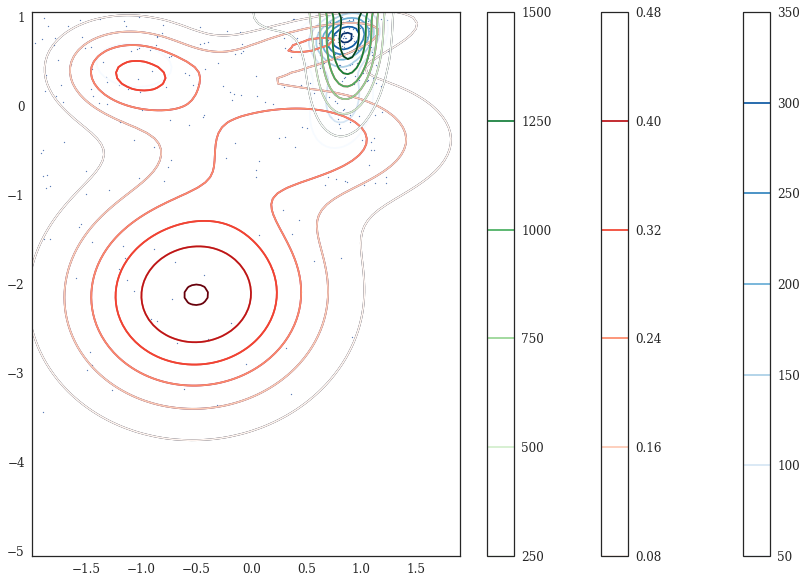

In [110]:
field=2.0
instsf = SF.obsSF[field].SF_model
instdf = SF.obsSF[field].DF_model
plt.figure(figsize=(15,10))

plt.scatter(instsf.y_s, instsf.x_s, s=1)
#plt.scatter(instsf.x_s, instsf.y_s, s=0.1)

#instsf.params_f = instsf.unscaleParams(instsf.params_f_scaled)

x = np.linspace(instdf.rngy_s[0], instdf.rngy_s[1], 100)
y = np.linspace(instdf.rngx_s[0], instdf.rngx_s[1], 100)
xx, yy = np.meshgrid(x, y)

#plt.scatter(instsf.params_f_scaled[:,0], instsf.params_f_scaled[:,1], c='g')
#plt.scatter(instsf.params_i[:,0], instsf.params_i[:,1], c='r')

all_pars = StatisticalModels.gmm_product_p(instsf.params_f_scaled, instsf.params_df)
all_pars = all_pars.reshape(-1, all_pars.shape[-1])
zz = StatisticalModels.bivGaussMix_vect(all_pars, yy, xx)
plt.contour(x, y, zz, cmap='Blues')
plt.colorbar()

all_pars = instsf.params_f_scaled
zz = StatisticalModels.bivGaussMix_vect(all_pars, yy, xx)
plt.contour(x, y, zz)
plt.contour(x, y, zz, cmap='Reds')
plt.colorbar()

all_pars = instsf.params_df
zz = StatisticalModels.bivGaussMix_vect(all_pars, yy, xx)
plt.contour(x, y, zz)
plt.contour(x, y, zz, cmap='Greens')
plt.colorbar()

## Load in premade selection function

In [55]:
%%time
# Load observable selection function
SF.load_obsSF(folder+'Galaxia_obsSFemcee.pickle')
#SF.load_obsSF(folder+'/Galaxia_obsSF.pickle')

Unpickling colour-magnitude interpolant dictionaries...
...done.

CPU times: user 36 ms, sys: 104 ms, total: 140 ms
Wall time: 259 ms


In [10]:
# Load intrinsic selection function
SF.load_intSF(folder+'/Galaxia_intSF.pickle')

Unpickling intrinsic selection function...
...done.



## MCMC around local optima

Again, MCMC runs have been done previously so if you used SF.load_obsSF(), they will already exist.
If not, the emcee run for 2000 iterations takes ~2h

In [11]:
from seestar import SFInstanceClasses
import pickle
from copy import deepcopy

In [14]:
%%time
for field in list(SF.pointings.fieldID):
    inst = SF.obsSF[field].SF_model
    inst.runningL=True
    inst.optimizeParams(method='emceeBall', init='reset')

init,  reset
initial parameters [[-4.17838255  0.60042245  4.00045082  5.57702447  0.0159517   0.61505256]
 [ 0.15729628 -0.91743333  0.5005584   2.41079562  1.35527681  0.05615077]
 [ 0.49339597  0.76811856  0.1773772   4.41562592  2.47808452  0.06247564]]
itern: 1, logL: 15222.70, sum log(f(xi)): 18316.26, integral: 3093.56                
Initparam likelihood: 15222.70
itern: 0, logL: 15222.70, sum log(f(xi)): 18316.26, integral: 3093.56                \nInit  lnl:  -15222.700901748309 \n
emcee with 2000 iterations...
itern: 46384, logL: 15232.18, sum log(f(xi)): 18300.52, integral: 3068.34                
itern: 46386, logL: 15236.38, sum log(f(xi)): 18359.82, integral: 3123.44                
 emceeBall: lnprob=15236, time=3211
init,  reset
initial parameters [[ -2.68706967  -0.38594158   1.04282587   7.92005862   1.29764421
    5.38147109]
 [  0.38211516  -1.9875036    0.25763134  18.03415267   0.26860365
    1.77964795]
 [  0.38211516  -1.9875036    0.25763136 111.19048091   1.6

In [15]:
inst = deepcopy(SF.obsSF)
obsSF_path = folder+'/Galaxia_obsSFemceee.pickle'
obsSF_dicts = SFInstanceClasses.obsSF_classtodict(inst)

for field in list(SF.pointings.fieldID):
    delattr(obsSF_dicts[field]['SF_model']['output'], 'lnprobfn')
    
with open(obsSF_path, 'wb') as handle:
    pickle.dump(obsSF_dicts, handle, protocol=2)

# Load data files

In [58]:
# Load in spectroscopic data
survey = pd.read_csv(folder + '/Galaxia_sf_survey.csv')
# Calculate colour and magnitude of spectroscopic data
survey['Colour'], survey['Happ'] = IsoCalculator.ColourMapp(survey.ageGyr, survey.mh, survey.mass, survey.s)

# Separate spectroscopic data into field 1 and field 2, 3 overlapping
survey1 = survey[survey.fieldID == 1.0]
survey23 = survey[survey.fieldID.apply(lambda x: x in [2.0,3.0])]

In [17]:
s1 = get_spectro(1.0)

In [13]:
# Load in field 1 photometric data
full1 = pd.read_csv(folder+'/photometric/'+str(1.0)+'.csv')
full1['Colour'] = full1['Japp']-full1['Kapp']
full1.rename(index=str, columns={'feh':'mh', 'smass':'mass','rad':'s'}, inplace=True)
full1['Colour'], full1['Happ'] = IsoCalculator.ColourMapp(full1.ageGyr, full1.mh, full1.mass, full1.s)

In [59]:
# Load in field 2, 3 photometric data

full23 = pd.DataFrame()
fields= [2.0,3.0]
for field in fields:
    full23 = pd.concat((full23, pd.read_csv(folder+'/photometric/'+str(field)+'.csv')))
full23['Colour'] = full23['Japp']-full23['Kapp']
full23.rename(index=str, columns={'feh':'mh', 'smass':'mass','rad':'s'}, inplace=True)
# Recalculate to make colour and apparent magnitude agree
full23['Colour'], full23['Happ'] = IsoCalculator.ColourMapp(full23.ageGyr, full23.mh, full23.mass, full23.s)

In [60]:
survey23 = survey23.drop_duplicates(subset=['glon','glat'], keep='first', inplace=False)
full23 = full23.drop_duplicates(subset=['glon','glat'], keep='first', inplace=False)

# Calculate SF probabilities

In [61]:
# Percentile threshold
s1_prob = 31.73*0.01
# Number of samples
Ns = 25

## Field 1
- For calculating probabilities you can use the union calculation (which takes longer for large datasets and is memory intensive.
- Or if you know that the fields are not overlapping you can calculate direct from the obsSF instances.
- For field 1 we'll demonstrate both.

In [17]:
field=1.0
# Get burnt chain
sampler = SF.obsSF[field].SF_model.output
burnt_chain = sampler.chain[:,sampler.chain.shape[1]/2:sampler.chain.shape[1]:3, :].copy()
burnt_prob = sampler.lnprobability[:,sampler.chain.shape[1]/2:sampler.chain.shape[1]:3].copy()
# Take random set of samples within the 68.37 percentile (1sigma)
prob = np.sort(burnt_prob.flatten())
s1_threshold = prob[int(s1_prob*len(prob)):][0]
sample_threshold = burnt_chain[burnt_prob>s1_threshold]
posterior_samples = sample_threshold[(np.random.rand(Ns)*sample_threshold.shape[0]).astype(int)].reshape(-1,3,6)
# Get highest probability parameters
index = np.unravel_index(np.argmax(sampler.lnprobability), sampler.lnprobability.shape)
best = sampler.chain[index].reshape(-1,3,6)[0].copy()

In [18]:
%%time
# Generate observable coord sample from union calculation
instance = SF.obsSF[field].SF_model
params_f = instance.params_f.copy()
# Condition that stars lie within cm boundaries
con_bound = (full1.Happ>SF.obsSF[field].SF_magrange[0])&(full1.Happ<SF.obsSF[field].SF_magrange[1])&\
            (full1.Colour>SF.obsSF[field].SF_colrange[0])&(full1.Colour<SF.obsSF[field].SF_colrange[1])

instance.params_f = instance.unscaleParams(best)
full1['union_f'] = \
    SF(full1, method='observable', coords=['Happ', 'Colour'], angle_coords=['glon', 'glat']).union
full1['union_f'][~con_bound] = 0.
instance.params_f = params_f

Calculating all SF values...
...Assigning: 2160082/2160082        
Calculating: 2160082/2160082        ...done
Calculating union contribution...
...done
CPU times: user 1min 42s, sys: 2.69 s, total: 1min 44s
Wall time: 1min 47s


/home/andy/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [19]:
%%time
# Generate posterior coord samples straight from obsSF
for i in range(Ns):
    
    rand_pars = posterior_samples[i].copy()
    instance.params_f = instance.unscaleParams(rand_pars)
    
    full1['union_%d'%i] = instance(full1.Happ, full1.Colour)
    
    full1['union_%d'%i][~con_bound] = 0.
    
instance.params_f = params_f

/home/andy/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


CPU times: user 33.6 s, sys: 11.1 s, total: 44.7 s
Wall time: 43.5 s


In [45]:
%%time
# Generate intrinsic coord sample from union calculation
full1['union_int_f'] = \
    SF(full1, method='intrinsic', coords=['ageGyr', 'mh', 's', 'mass'], angle_coords=['glon', 'glat']).union
full1['union_int_f'][~con_bound] = 0.

Calculating all SF values...
...Assigning: 2160082/2160082        
Calculating: 2160082/2160082        ...done
Calculating union contribution...
...done


/home/andy/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


ValueError: cannot reindex from a duplicate axis

In [ ]:
# Generate posterior intrinsic coord samples straigh from intSF
for i in range(Ns):
    
    rand_pars = posterior_samples[i].copy()
    instance.params_f = instance.unscaleParams(rand_pars)
    
    full1['union_int_%d'%i] = SF.instanceSF((full1.ageGyr, full1.mh, full1.mass, full1.s), SF.obsSF[field])
    
    full1['union_int_%d'%i][~con_bound] = 0.
    
instance.params_f = params_f

# Field 2 & 3

In [64]:
field = 2.0

shp = SF.obsSF[field].SF_model.output.chain.shape[:2] + (SF.obsSF[2.0].SF_model.nComponents,) + (-1,)
chain = SF.obsSF[field].SF_model.output.chain.reshape(shp)
flatchain = SF.obsSF[field].SF_model.output.flatchain


sampler = SF.obsSF[field].SF_model.output
burnt_chain = sampler.chain[:,sampler.chain.shape[1]/2:sampler.chain.shape[1]:3, :].copy()
burnt_prob = sampler.lnprobability[:,sampler.chain.shape[1]/2:sampler.chain.shape[1]:3].copy()

prob = np.sort(burnt_prob.flatten())
s1_threshold = prob[int(s1_prob*len(prob)):][0]
sample_threshold = burnt_chain[burnt_prob>s1_threshold]

posterior2 = sample_threshold[(np.random.rand(Ns)*sample_threshold.shape[0]).astype(int)].reshape(-1, 3, 6)

AttributeError: BGM_TNC instance has no attribute 'output'

In [21]:
field = 3.0

shp = SF.obsSF[field].SF_model.output.chain.shape[:2] + (SF.obsSF[2.0].SF_model.nComponents,) + (-1,)
chain = SF.obsSF[field].SF_model.output.chain.reshape(shp)
flatchain = SF.obsSF[field].SF_model.output.flatchain

sampler = SF.obsSF[field].SF_model.output
burnt_chain = sampler.chain[:,sampler.chain.shape[1]/2:sampler.chain.shape[1]:3, :].copy()
burnt_prob = sampler.lnprobability[:,sampler.chain.shape[1]/2:sampler.chain.shape[1]:3].copy()

prob = np.sort(burnt_prob.flatten())
s1_threshold = prob[int(s1_prob*len(prob)):][0]
sample_threshold = burnt_chain[burnt_prob>s1_threshold]

posterior3 = sample_threshold[(np.random.rand(Ns)*sample_threshold.shape[0]).astype(int)].reshape(-1, 3, 6)

In [22]:
instance2 = SF.obsSF[2.0].SF_model
instance3 = SF.obsSF[3.0].SF_model
params_f2 = instance2.params_f.copy()
params_f3 = instance3.params_f.copy()

con_bound = (full23.Happ>SF.obsSF[field].SF_magrange[0])&(full23.Happ<SF.obsSF[field].SF_magrange[1])&\
            (full23.Colour>SF.obsSF[field].SF_colrange[0])&(full23.Colour<SF.obsSF[field].SF_colrange[1])

for i in range(Ns):
    
    rand_pars2 = posterior2[i].copy()
    instance2.params_f = instance2.unscaleParams(rand_pars2)
    rand_pars3 = posterior3[i].copy()
    instance3.params_f = instance3.unscaleParams(rand_pars3)
    
    full23['union_%d'%i] = \
        SF(full23, method='observable', coords=['Happ', 'Colour'], angle_coords=['glon', 'glat']).union
    full23['union_%d'%i][~con_bound] = 0.
    
instance2.params_f = params_f2
instance3.params_f = params_f3
full23['union_f'] = \
        SF(full23, method='observable', coords=['Happ', 'Colour'], angle_coords=['glon', 'glat']).union
full23['union_f'][~con_bound] = 0.

Calculating all SF values...
...Assigning: 10621/10621        
Calculating: 10621/10621        ...done
Calculating union contribution...
...done
Calculating all SF values...
...Assigning: 10621/10621        

/home/andy/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()



Calculating: 10621/10621        ...done
Calculating union contribution...
...done
Calculating all SF values...
...Assigning: 10621/10621        
Calculating: 10621/10621        ...done
Calculating union contribution...
...done
Calculating all SF values...
...Assigning: 10621/10621        
Calculating: 10621/10621        ...done
Calculating union contribution...
...done
Calculating all SF values...
...Assigning: 10621/10621        
Calculating: 10621/10621        ...done
Calculating union contribution...
...done
Calculating all SF values...
...Assigning: 10621/10621        
Calculating: 10621/10621        ...done
Calculating union contribution...
...done
Calculating all SF values...
...Assigning: 10621/10621        
Calculating: 10621/10621        ...done
Calculating union contribution...
...done
Calculating all SF values...
...Assigning: 10621/10621        
Calculating: 10621/10621        ...done
Calculating union contribution...
...done
Calculating all SF values...
...Assigning: 1062

/home/andy/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [28]:
instance2 = SF.obsSF[2.0].SF_model
instance3 = SF.obsSF[3.0].SF_model
params_f2 = instance2.params_f.copy()
params_f3 = instance3.params_f.copy()

con_bound = (full23.Happ>SF.obsSF[field].SF_magrange[0])&(full23.Happ<SF.obsSF[field].SF_magrange[1])&\
            (full23.Colour>SF.obsSF[field].SF_colrange[0])&(full23.Colour<SF.obsSF[field].SF_colrange[1])

for i in range(Ns):
    
    rand_pars2 = posterior2[i].copy()
    instance2.params_f = instance2.unscaleParams(rand_pars2)
    rand_pars3 = posterior3[i].copy()
    instance3.params_f = instance3.unscaleParams(rand_pars3)
    
    full23['union_%d'%i] = \
        SF(full23, method='intrinsic', coords=['ageGyr', 'mh', 's', 'mass'], angle_coords=['glon', 'glat']).union
    full23['union_%d'%i][~con_bound] = 0.
    
instance2.params_f = params_f2
instance3.params_f = params_f3
full23['union_f'] = \
        SF(full23, method='intrinsic', coords=['ageGyr', 'mh', 's', 'mass'], angle_coords=['glon', 'glat']).union
full23['union_f'][~con_bound] = 0.

Calculating all SF values...
...Assigning: 10621/10621        
Calculating: 10621/10621        ...done
Calculating union contribution...
...done
Calculating all SF values...
...Assigning: 10621/10621        
Calculating: 10621/10621        

/home/andy/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


...done
Calculating union contribution...
...done
Calculating all SF values...
...Assigning: 10621/10621        
Calculating: 10621/10621        ...done
Calculating union contribution...
...done
Calculating all SF values...
...Assigning: 10621/10621        
Calculating: 10621/10621        ...done
Calculating union contribution...
...done
Calculating all SF values...
...Assigning: 10621/10621        
Calculating: 10621/10621        ...done
Calculating union contribution...
...done
Calculating all SF values...
...Assigning: 10621/10621        
Calculating: 10621/10621        ...done
Calculating union contribution...
...done
Calculating all SF values...
...Assigning: 10621/10621        
Calculating: 10621/10621        ...done
Calculating union contribution...
...done
Calculating all SF values...
...Assigning: 10621/10621        
Calculating: 10621/10621        ...done
Calculating union contribution...
...done
Calculating all SF values...
...Assigning: 10621/10621        
Calculating: 1062

/home/andy/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [67]:
instance2.params_f.shape

(2, 6)

In [111]:
instance2 = SF.obsSF[2.0].SF_model
instance3 = SF.obsSF[3.0].SF_model

con_bound = (full23.Happ>8)&(full23.Happ<13.5)&\
            (full23.Colour>0.5)&(full23.Colour<SF.obsSF[field].SF_colrange[1])

full23['union_f'] = \
        SF(full23, method='intrinsic', coords=['ageGyr', 'mh', 's', 'mass'], angle_coords=['glon', 'glat']).union
full23['union_f'][~con_bound] = 0.

Calculating all SF values...
...Assigning: 10621/10621        
Calculating: 10621/10621        

AttributeError: SFGenerator instance has no attribute 'instanceSF'

# Plot results

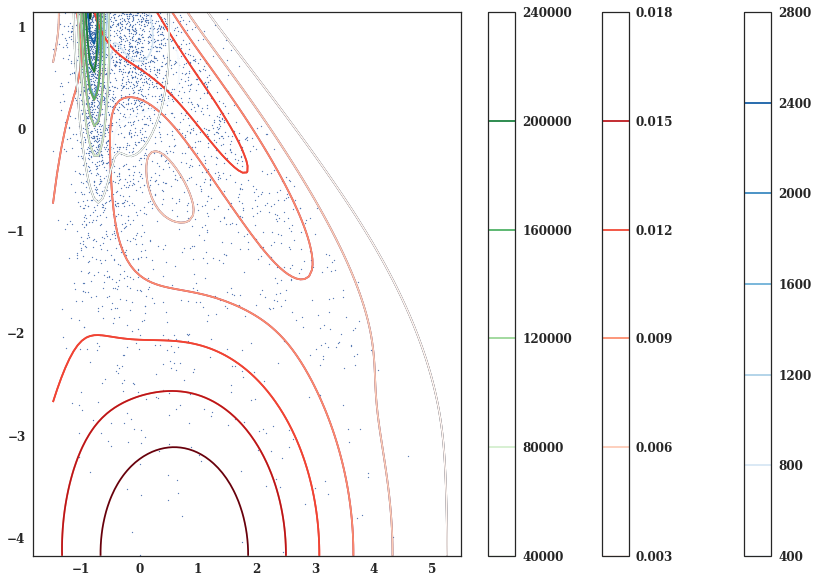

In [34]:
field=1.0
instsf = SF.obsSF[field].SF_model
instdf = SF.obsSF[field].DF_model
plt.figure(figsize=(15,10))

plt.scatter(instsf.y_s, instsf.x_s, s=1)
#plt.scatter(instsf.x_s, instsf.y_s, s=0.1)

#instsf.params_f = instsf.unscaleParams(instsf.params_f_scaled)

x = np.linspace(instsf.rngy_s[0], instsf.rngy_s[1], 100)
y = np.linspace(instsf.rngx_s[0], instsf.rngx_s[1], 100)
xx, yy = np.meshgrid(x, y)

#plt.scatter(instsf.params_f_scaled[:,0], instsf.params_f_scaled[:,1], c='g')
#plt.scatter(instsf.params_i[:,0], instsf.params_i[:,1], c='r')

all_pars = StatisticalModels.gmm_product_p(instsf.params_f_scaled, instsf.params_df)
all_pars = all_pars.reshape(-1, all_pars.shape[-1])
zz = StatisticalModels.bivGaussMix_vect(all_pars, yy, xx)
plt.contour(x, y, zz, cmap='Blues')
plt.colorbar()

all_pars = instsf.params_f_scaled
zz = StatisticalModels.bivGaussMix_vect(all_pars, yy, xx)
plt.contour(x, y, zz)
plt.contour(x, y, zz, cmap='Reds')
plt.colorbar()

all_pars = instsf.params_df
zz = StatisticalModels.bivGaussMix_vect(all_pars, yy, xx)
plt.contour(x, y, zz)
plt.contour(x, y, zz, cmap='Greens')
plt.colorbar()


In [ ]:
all_pars = StatisticalModels.gmm_product_p(instsf.params_f_scaled, instsf.params_df)
all_pars = all_pars.reshape(-1, all_pars.shape[-1])
zz = StatisticalModels.bivGaussMix_vect(all_pars, yy, xx)
plt.contour(x, y, zz, cmap='Blues')
plt.colorbar()

# New histogram plots

In [78]:
import StatisticalModels

In [79]:
nullfmt = NullFormatter()         # no labels
font = {'family' : 'serif', 'weight' : 'normal',
        'size'   : 80}
legend = {'fontsize': 20}
matplotlib.rc('font', **font)
matplotlib.rc('legend', **legend)
matplotlib.rc('axes', labelsize= 20)

In [80]:
field=1.0
instsf = SF.obsSF[field].SF_model
instdf = SF.obsSF[field].DF_model

KeyError: 1.0

In [81]:
x = np.linspace(instsf.rngy[0], instsf.rngy[1], 100)
y = np.linspace(instsf.rngx[0], instsf.rngx[1], 100)
xx, yy = np.meshgrid(x, y)

In [82]:
x = np.linspace(instsf.rngy_s[0], instsf.rngy_s[1], 100)
y = np.linspace(instsf.rngx_s[0], instsf.rngx_s[1], 100)
xx, yy = np.meshgrid(x, y)

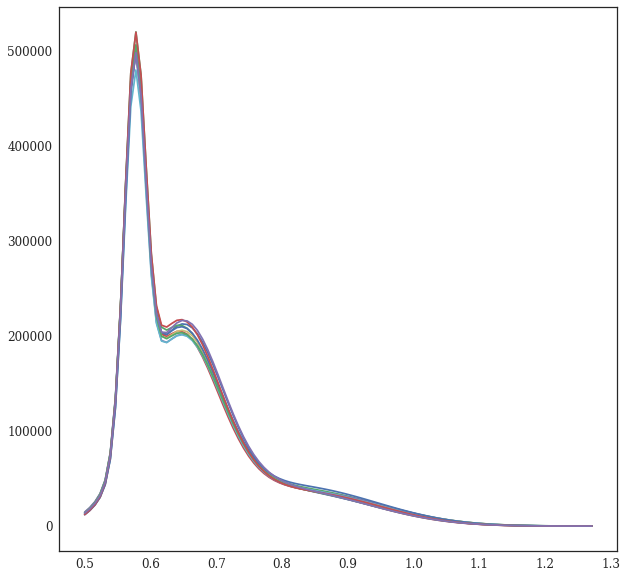

In [119]:
plt.figure(figsize=(10,10))
for sample in posterior_samples[:10,...]:
    sample = instsf.unscaleParams(sample)
    pars = StatisticalModels.gmm_product_p(sample, instdf.params_f)
    pars = pars.reshape(-1, pars.shape[-1])
    
    zz = StatisticalModels.bivGaussMix_vect(pars, yy, xx)
    z_x = np.sum(zz, axis=0)
    plt.plot(x, z_x)

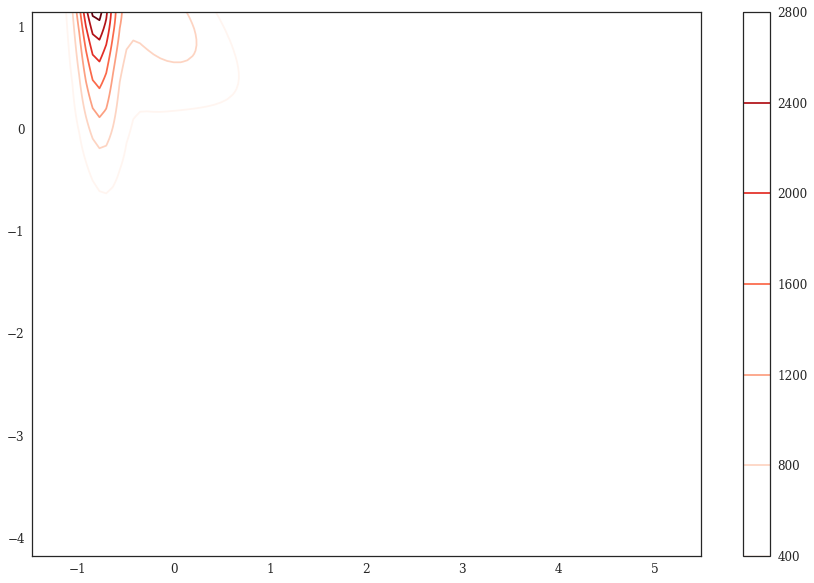

In [109]:
plt.figure(figsize=(15,10))

x = np.linspace(instsf.rngy_s[0], instsf.rngy_s[1], 100)
y = np.linspace(instsf.rngx_s[0], instsf.rngx_s[1], 100)
xx, yy = np.meshgrid(x, y)

all_pars = posterior_samples[5,:,:]
#zz = StatisticalModels.bivGaussMix_vect(all_pars, yy, xx)

all_pars = StatisticalModels.gmm_product_p(all_pars, instsf.params_df)
all_pars = all_pars.reshape(-1, all_pars.shape[-1])
zz = StatisticalModels.bivGaussMix_vect(all_pars, yy, xx)

plt.contour(x, y, zz, cmap='Reds')
plt.colorbar()

In [101]:
posterior_samples[:,:,5]

array([[0.38406707, 0.16483758, 0.09802033],
       [0.30831127, 0.10398746, 0.1739804 ],
       [0.51678962, 0.06923335, 0.0874405 ],
       [0.36145631, 0.13771013, 0.08876128],
       [0.44873253, 0.10358144, 0.09672916],
       [0.60629022, 0.05538319, 0.10837959],
       [0.47288758, 0.06211277, 0.08683522],
       [0.31907808, 0.10653507, 0.12125939],
       [0.38285304, 0.11827663, 0.07897349],
       [0.42709891, 0.1284435 , 0.10370847],
       [0.32891224, 0.09929267, 0.1130262 ],
       [0.47827324, 0.07292945, 0.10453741],
       [0.44608398, 0.10790862, 0.13870558],
       [0.52818489, 0.078908  , 0.14755813],
       [0.38524413, 0.06643693, 0.13756841],
       [0.5649974 , 0.09757754, 0.09786492],
       [0.67276827, 0.07308655, 0.09916473],
       [0.33978509, 0.08055071, 0.08008283],
       [0.54855378, 0.07327332, 0.15294564],
       [0.55001988, 0.12628442, 0.08463261],
       [0.58138699, 0.09065551, 0.14739585],
       [0.3067184 , 0.06681642, 0.10329575],
       [0.

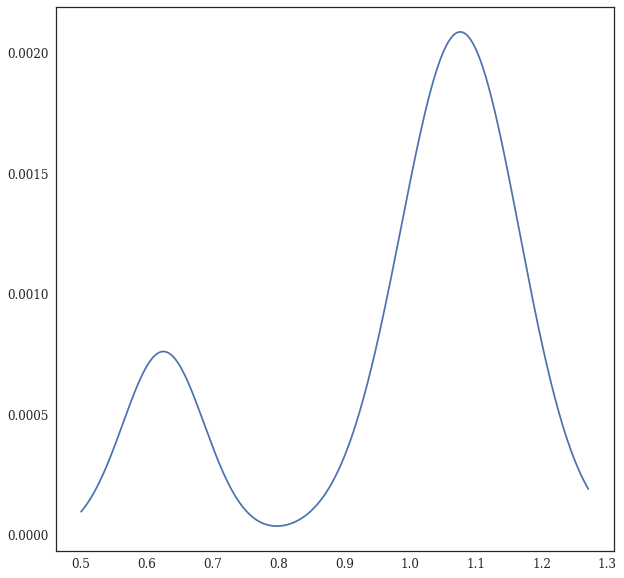

In [99]:
plt.figure(figsize=(10,10))

i=2
sample= posterior_samples[i,...]

pars = StatisticalModels.gmm_product_p(sample, instdf.params_f)
pars = pars.reshape(-1, pars.shape[-1])

zz = StatisticalModels.bivGaussMix_vect(pars, yy, xx)
z_x = np.sum(zz, axis=0)
plt.plot(x, z_x)

In [94]:
for sample in posterior_samples:
    print sample

[[-3.86043341  0.82679329  2.15773546  2.68133497  0.06386451  0.38406707]
 [ 0.20519622 -1.30568162  2.09147624  3.32588836  1.45273854  0.16483758]
 [ 0.45406844  0.8288072   0.13226425 18.04303645  2.45758283  0.09802033]]
[[-3.70909744  0.93477981  1.89871367  3.10745334  0.05007974  0.30831127]
 [-0.92850566 -1.20753019  0.84035455  3.03185933  1.41453923  0.10398746]
 [ 0.29650558  0.95369321  0.26067687 21.67250483  2.49600578  0.1739804 ]]
[[-4.10738823e+00  5.02691001e-01  3.23916651e+00  3.35185236e+00
   3.04299820e-03  5.16789624e-01]
 [ 2.07587406e-01 -1.02843002e+00  7.21016481e-01  2.64964904e+00
   1.17753456e+00  6.92333492e-02]
 [ 3.62141387e-01  8.76945408e-01  2.02395028e-01  1.08246290e+01
   2.50773882e+00  8.74405040e-02]]
[[-3.74321252e+00  1.15171529e+00  1.75166167e+00  2.55211505e+00
   2.15051360e-02  3.61456307e-01]
 [ 1.03586226e-02 -1.41089184e+00  1.51221646e+00  2.76277371e+00
   1.67364205e+00  1.37710126e-01]
 [ 5.71416933e-02  1.20871279e+00  1.38902

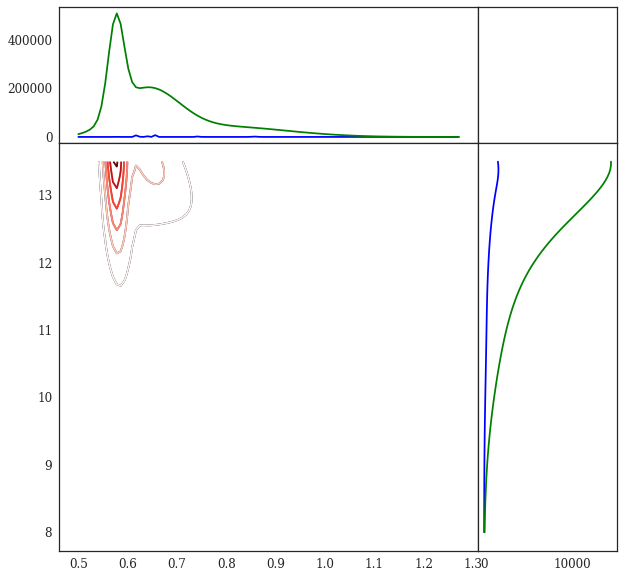

In [48]:
fig, axes = plt.subplots(2,2, figsize=(10,10), gridspec_kw={'height_ratios':(1,3), 'width_ratios':(3,1)}, sharex='col', sharey='row')

all_pars = StatisticalModels.gmm_product_p(instsf.params_f, instdf.params_f)
all_pars = all_pars.reshape(-1, all_pars.shape[-1])

plt.sca(axes[1,0])
zz = StatisticalModels.bivGaussMix_vect(all_pars, yy, xx)
plt.contour(x, y, zz)
plt.contour(x, y, zz, cmap='Reds')
#plt.colorbar()

plt.sca(axes[0,0])
z_x = GMM_1D(x, all_pars[:,1], all_pars[:,3], all_pars[:,5])
plt.plot(x, z_x, c='b')
z_x = np.sum(zz, axis=0)
plt.plot(x, z_x, c='g')

plt.sca(axes[1,1])
z_y = GMM_1D(y, all_pars[:,0], all_pars[:,2], all_pars[:,5])
plt.plot(z_y, y, c='b')
z_y = np.sum((zz[:,:-1]+zz[:,1:])*(y[1:]-y[:-1])/2, axis=1)
plt.plot(z_y, y, c='g')

plt.subplots_adjust(hspace=0, wspace=0)


In [39]:
def GMM_1D(x, means, variances, weights):
    
    norm = 1/(np.sqrt(2*np.pi*variances[np.newaxis,:]))
    exp = np.exp(-(x[:,np.newaxis]-means[np.newaxis,:])**2 / (variances[np.newaxis,:])**2)    
    return np.sum(norm*exp*weights, axis=1)

In [40]:
def GMM_1D_ex(x, means, variances, weights):
    
    norm = 1/(np.sqrt(2*np.pi*variances[np.newaxis,:]))
    exp = np.exp(-(x[:,np.newaxis]-means[np.newaxis,:])**2 / (variances[np.newaxis,:])**2)    
    return norm*exp

In [89]:
all_pars[:,1]

array([ 0.60042245, -0.91743333,  0.76811856])

In [88]:
GMM_1D_ex(y, all_pars[:,1], all_pars[:,3], all_pars[:,5])

array([[0.08106544, 0.04123104, 0.05412708],
       [0.0824091 , 0.04377514, 0.05561673],
       [0.08375944, 0.04642995, 0.05713042],
       [0.08511607, 0.04919673, 0.05866789],
       [0.08647857, 0.0520765 , 0.06022884],
       [0.08784653, 0.05506995, 0.06181297],
       [0.08921952, 0.05817749, 0.06341994],
       [0.09059711, 0.06139921, 0.06504936],
       [0.09197885, 0.06473482, 0.06670084],
       [0.09336428, 0.06818369, 0.06837395],
       [0.09475294, 0.07174481, 0.07006821],
       [0.09614436, 0.07541677, 0.07178315],
       [0.09753806, 0.07919774, 0.07351822],
       [0.09893354, 0.08308546, 0.07527289],
       [0.10033032, 0.08707725, 0.07704655],
       [0.10172788, 0.09116997, 0.07883859],
       [0.10312571, 0.09536002, 0.08064837],
       [0.10452329, 0.09964333, 0.0824752 ],
       [0.1059201 , 0.10401539, 0.08431837],
       [0.10731559, 0.10847118, 0.08617714],
       [0.10870924, 0.11300523, 0.08805074],
       [0.11010049, 0.1176116 , 0.08993837],
       [0.

In [73]:
z_x = GMM_1D(x, all_pars[:,0], all_pars[:,2], all_pars[:,5])
z_y = GMM_1D(y, all_pars[:,1], all_pars[:,3], all_pars[:,5])

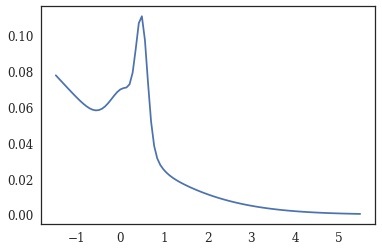

In [72]:
plt.plot(x, z_x)

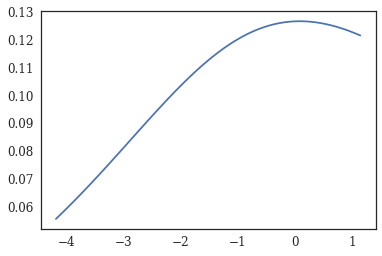

In [74]:
plt.plot(y, z_y)

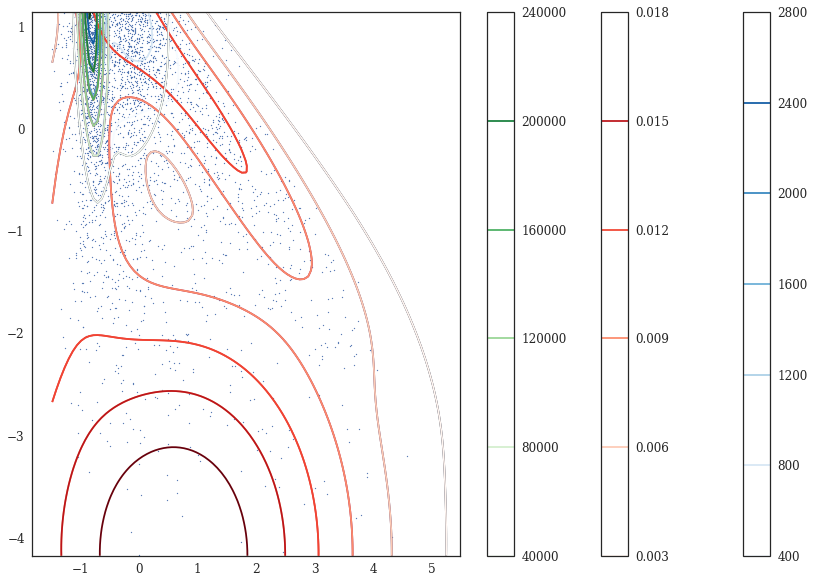

In [87]:
rand_pars

array([[-3.81729884,  0.73535876,  2.1748037 ,  3.48118134,  0.02959962,
         0.40750086],
       [-0.11869199, -0.80206417,  0.58660745,  2.36026944,  1.60378705,
         0.06318097],
       [-0.0209347 ,  1.37971081,  0.2097431 , 11.5332762 ,  2.51808936,
         0.11131624]])

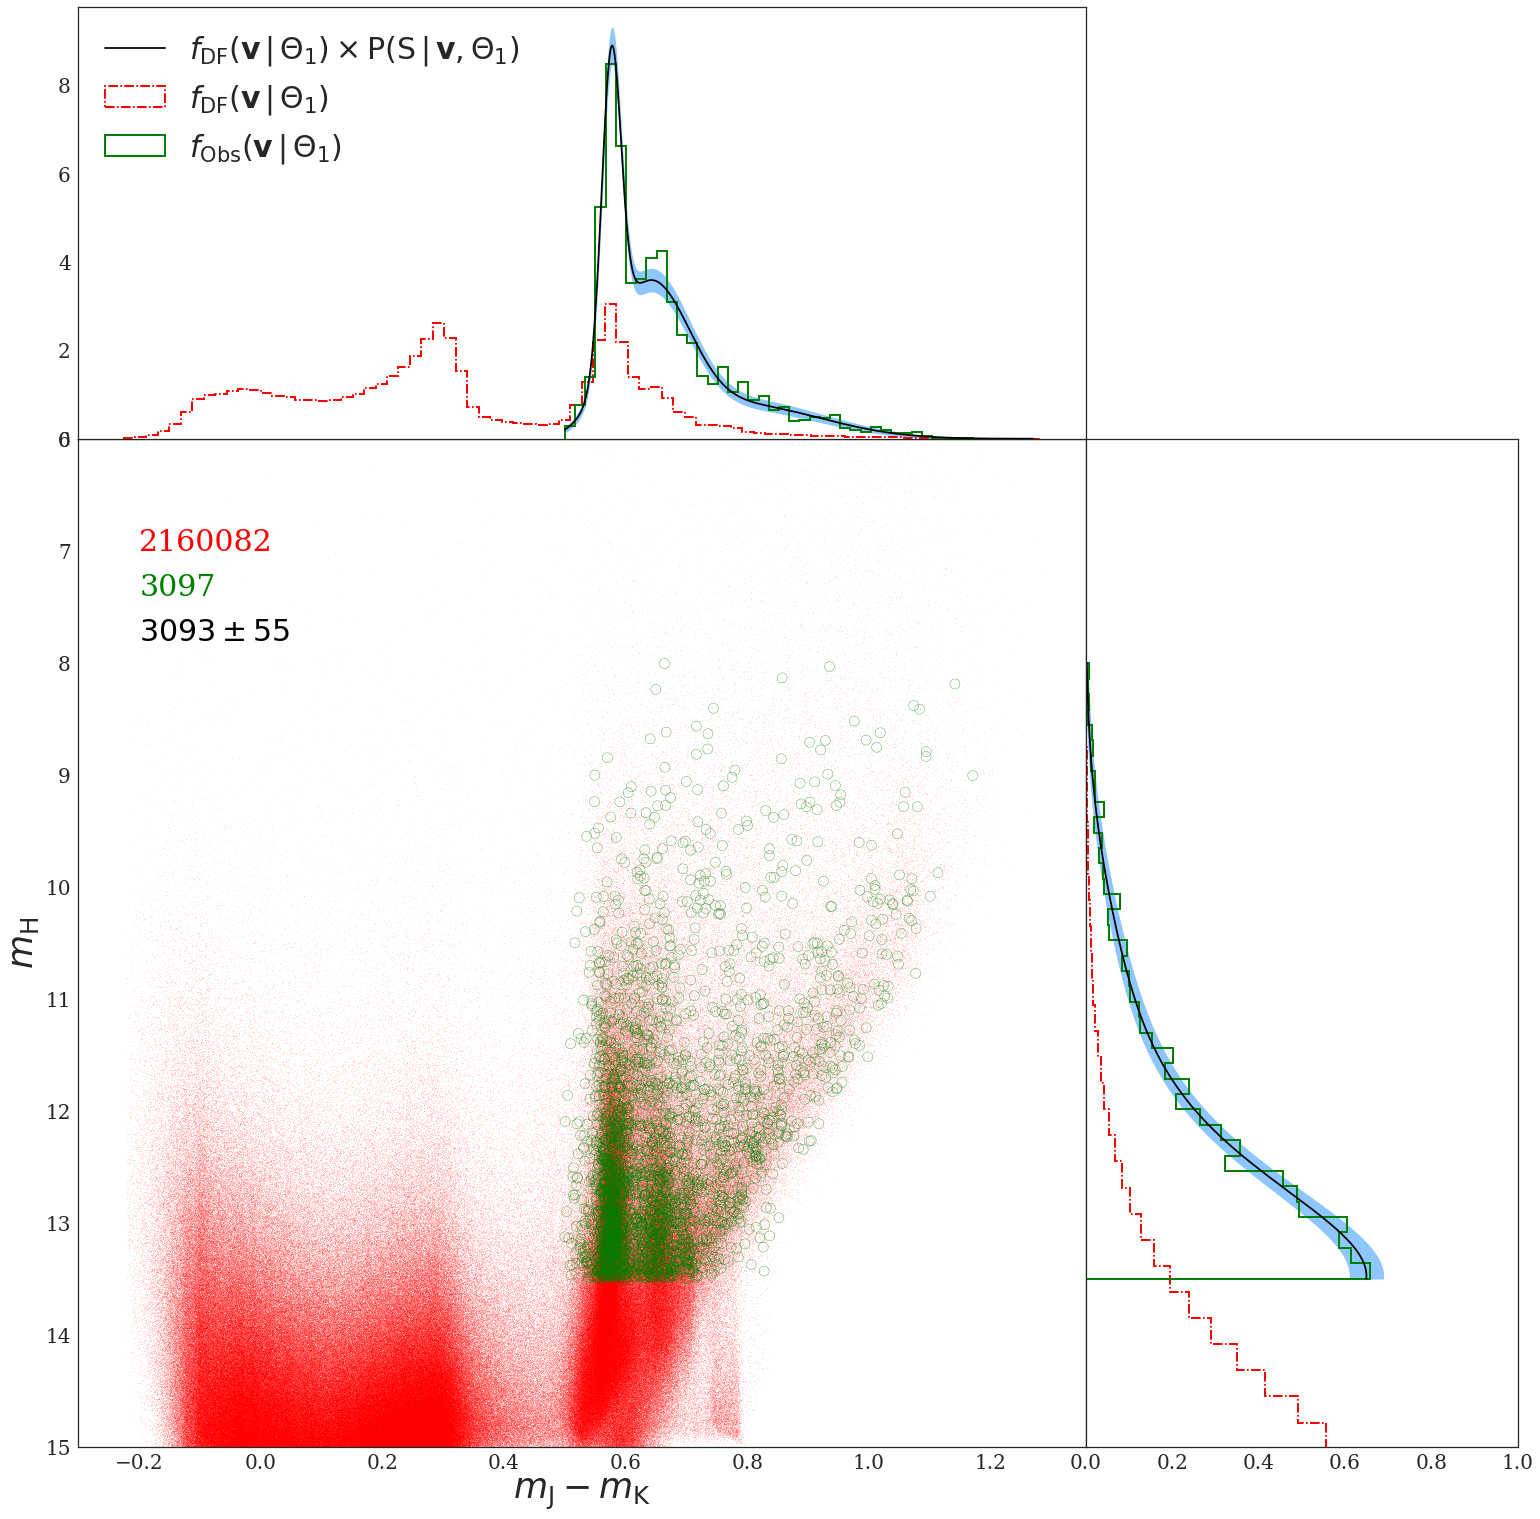

In [246]:
# start with a rectangular Figure
fig=plt.figure(1, figsize=(20, 20))

sml, big = (0.3, 0.7)
ax_c = plt.axes([0, 0, big, big])
ax_t = plt.axes([0, big, big, sml])
ax_s = plt.axes([big, 0., sml, big])

#xlim = (0, 13)
ylim = (15, 6)

# the scatter plot:
ax_c.scatter(full1.Colour, full1.Happ, s=0.01, c='r', rasterized=True)
ax_c.scatter(survey1.Colour, survey1.Happ, s=100, marker='o', c='none', edgecolors='g', rasterized=True)

#ax_c.set_xlim(xlim)
ax_c.set_ylim(ylim)

label1=r'$f_\mathrm{DF}(\mathbf{v} \,|\,\Theta_1)$'
label2=r'$f_\mathrm{Obs}(\mathbf{v} \,|\,\Theta_1)$'
label3=r'$f_\mathrm{DF}(\mathbf{v} \,|\,\Theta_1) \times \mathrm{P}(\mathrm{S}\,|\,\mathbf{v}, \Theta_1)$'

field=1.0

instsf = SF.obsSF[field].SF_model
instdf = SF.obsSF[field].DF_model
sf_pars = instsf.params_f
obs_pars = StatisticalModels.gmm_product_p(instsf.params_f, instdf.params_f)
obs_pars = obs_pars.reshape(-1, obs_pars.shape[-1])
#norm = np.sum(obs_pars[:,5])
df_pars = instsf.params_df

x = np.linspace(instsf.rngy[0], instsf.rngy[1], 500)
y = np.linspace(instsf.rngx[0], instsf.rngx[1], 400)
xx, yy = np.meshgrid(x, y)
zz = StatisticalModels.bivGaussMix_vect(obs_pars, yy, xx)

z_x = np.sum((zz[:-1,:]+zz[1:,:])*(yy[1:,:]-yy[:-1,:])/2, axis=0)
z_y = np.sum((zz[:,:-1]+zz[:,1:])*(xx[:,1:]-xx[:,:-1])/2, axis=1)
norm = np.sum((z_x[:-1]+z_x[1:])*(x[1:]-x[:-1]))/2

"""
for sample in posterior_samples[:25,...]:
    sample = instsf.unscaleParams(sample)
    pars = StatisticalModels.gmm_product_p(sample, instdf.params_f)
    pars = pars.reshape(-1, pars.shape[-1])
    zz = StatisticalModels.bivGaussMix_vect(pars, yy, xx)
    
    plt.sca(ax_t)
    z_x = np.sum((zz[:-1,:]+zz[1:,:])*(yy[1:,:]-yy[:-1,:])/2, axis=0)
    plt.plot(x, z_x/norm, color='c', alpha=0.5)

    plt.sca(ax_s)
    z_y = np.sum((zz[:,:-1]+zz[:,1:])*(xx[:,1:]-xx[:,:-1])/2, axis=1)
    plt.plot(z_y/norm, y, color='c', alpha=0.5)"""

plt.sca(ax_t)
spec_bins = 40
_=plt.hist(full1.Colour, label=label1, color='r', linestyle='-.', linewidth=2, 
           histtype='step', bins=80, normed=True)
_=plt.hist(survey1.Colour, label=label2, color='g', linestyle='-', linewidth=2, 
           histtype='step', bins=spec_bins, normed=True)
bin_width = _[1][1]-_[1][0]
z_x = np.sum((zz[:-1,:]+zz[1:,:])*(yy[1:,:]-yy[:-1,:])/2, axis=0)
plt.plot(x, z_x/norm, color='k', label=label3)
#plt.fill_between(x, (z_x-np.sqrt(z_x))/norm, (z_x+np.sqrt(z_x))/norm, color='b', alpha=0.5)
plt.fill_between(x, z_x*(1 - 1/np.sqrt(z_x*bin_width))/norm,  
                  z_x*(1 + 1/np.sqrt(z_x*bin_width))/norm, color='dodgerblue', alpha=0.5)
plt.legend(fontsize=30)

plt.sca(ax_s)
_=plt.hist(full1.Happ, color='r', linestyle='-.', linewidth=2, 
           histtype='step', bins=80, normed=True, orientation='horizontal')
_=plt.hist(survey1.Happ, color='g', linestyle='-', linewidth=2, 
           histtype='step', bins=40, normed=True, orientation='horizontal')
bin_width = _[1][1]-_[1][0]
z_y = np.sum((zz[:,:-1]+zz[:,1:])*(xx[:,1:]-xx[:,:-1])/2, axis=1)
# Shaded region for poisson noise
plt.fill_betweenx(y, z_y*(1 - 1/np.sqrt(z_y*bin_width))/norm,  
                  z_y*(1 + 1/np.sqrt(z_y*bin_width))/norm, color='dodgerblue', alpha=0.5)
plt.plot(z_y/norm, y, color='k')
plt.xlim(0,1)


    
    
ax_t.set_xlim(ax_c.get_xlim())
ax_s.set_ylim(ax_c.get_ylim())
ax_t.set_ylim(0, ax_t.get_ylim()[1])
ax_s.set_xlim(0, ax_s.get_xlim()[1])

plt.sca(ax_c)
textfont = {'fontsize':30}
plt.text(-0.2, 7., str(len(full1)), color='r', fontdict=textfont)
plt.text(-0.2, 7.4, str(len(survey1)), color='g', fontdict=textfont)
plt.text(-0.2, 7.8, r'$%d \pm %d$' % (norm, np.sqrt(norm)), color='k', fontdict=textfont)

ax_c.tick_params('x', labelsize=20)
ax_c.tick_params('y', labelsize=20)
ax_s.tick_params('both', which='both', left='off', labelleft='off', labelsize=20)
ax_t.tick_params('both', which='both', bottom='off', labelbottom='off', labelsize=20)

ax_c.set_xlabel(r'$m_\mathrm{J} - m_\mathrm{K}$', fontsize=35)
ax_c.set_ylabel(r'$m_\mathrm{H}$', fontsize=35)

#plt.setp(ax_t.get_legend().get_texts(), fontsize='30') 

plt.show()

fig.savefig('/home/andy/Documents/Research/SF/WriteUp/PaperFigs/G3_colmag_hist_joint1.png', bbox_inches='tight')
fig.savefig('/home/andy/Documents/Research/SF/WriteUp/PaperFigs/G3_colmag_hist_joint1.pdf', bbox_inches='tight')

In [138]:
df_rand.Colour

3       0.770152
4       0.769469
9       0.766420
11      0.749294
16      0.748487
18      0.750810
24      0.769470
27      0.753825
31      0.753848
32      0.750880
38      0.748709
49      0.749512
54      0.742183
61      0.743315
65      0.749901
67      0.750807
79      0.746696
92      0.744153
93      0.752427
109     0.764557
111     0.768933
117     0.742775
124     0.770779
125     0.655135
134     0.570991
144     0.630114
164     0.788955
170     0.769930
219     0.743251
224     0.770621
          ...   
4233    0.709367
4267    0.690787
4284    0.782452
4344    0.766849
4368    0.686387
4434    0.704368
4484    0.755342
4530    0.787007
4539    0.754382
4666    0.754781
4732    0.708066
4820    0.638043
4874    0.643404
4999    0.596151
5289    0.502493
5468    0.511253
5702    0.686464
5811    0.714025
5833    0.625648
5931    0.586591
5944    0.656406
5954    0.518139
5978    0.552607
5994    0.557513
6015    0.668975
6093    0.590315
6852    0.631483
7447    0.5251

In [243]:
xtest = np.random.rand(100000)
ytest = np.random.rand(100000)

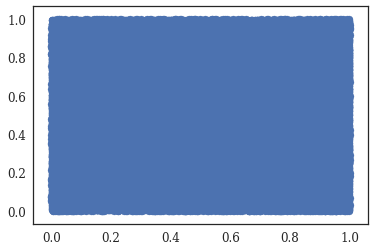

In [244]:
fig=plt.figure()
plt.scatter(xtest, ytest)
fig.savefig('/home/andy/Documents/Research/SF/WriteUp/PaperFigs/test_largefile.pdf', bbox_inches='tight')

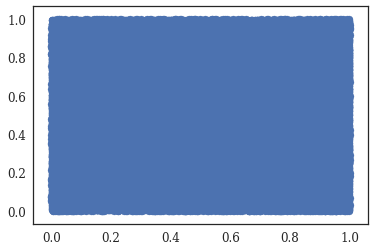

In [245]:
fig=plt.figure()
plt.scatter(xtest, ytest, rasterized=True)
fig.savefig('/home/andy/Documents/Research/SF/WriteUp/PaperFigs/test_largefile_rast.pdf', bbox_inches='tight')

In [149]:
instsf.rngy

(0.5, 1.2710749135969377)

In [223]:
df_rand = pd.DataFrame()
for i in range(100):
    df_rand = pd.concat((df_rand, full23[np.random.rand(len(full23)) < full23['union_f']][['Colour', 'Happ']].copy()))

In [219]:
df_rand = full23[np.random.rand(len(full23)) < full23['union_f']][['Colour', 'Happ']].copy()

In [224]:
len(df_rand)

55454

In [86]:
np.sum(full23.union_f>np.random.rand(len(full23)))

1431

((40,), (40,))
((40,), (40,))


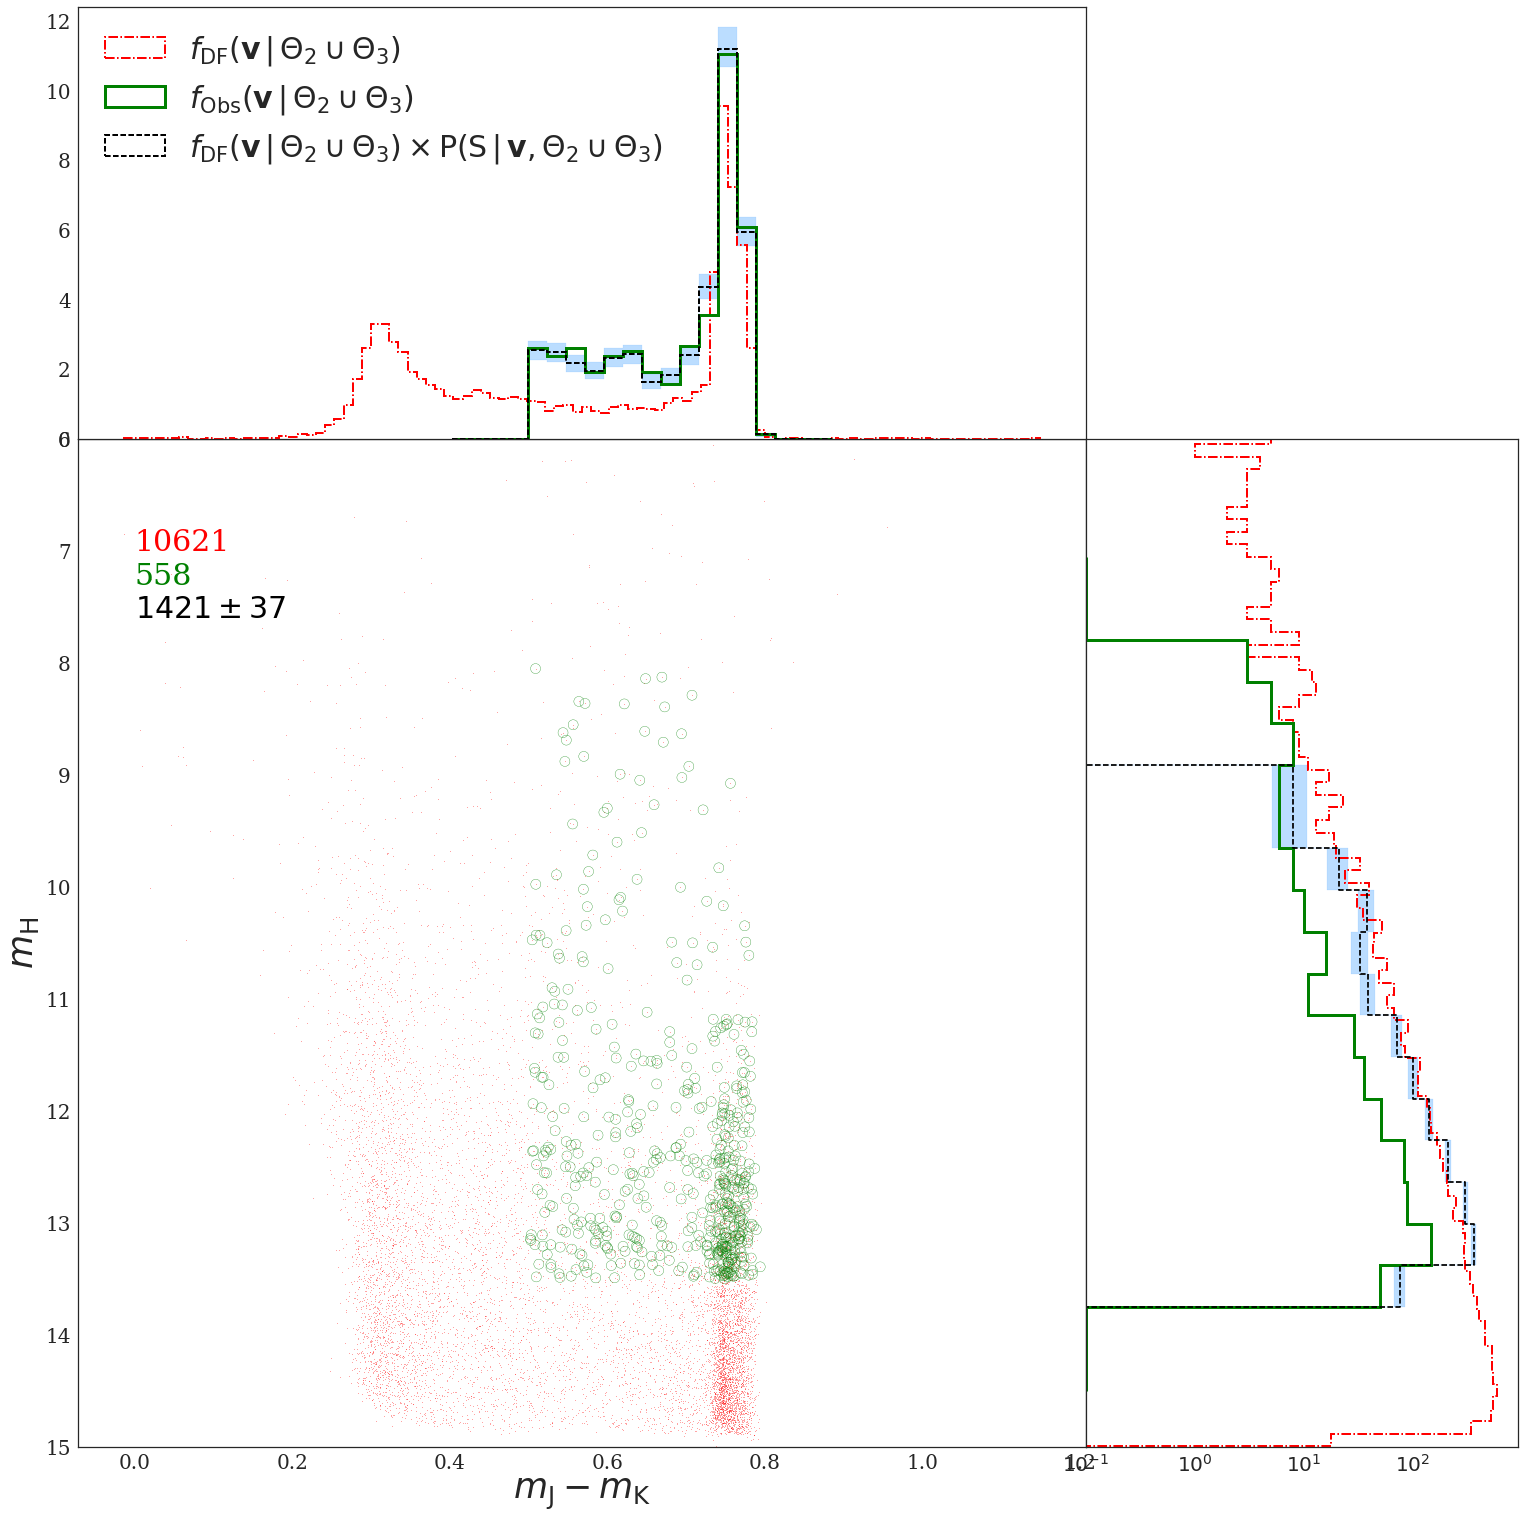

In [100]:
# start with a rectangular Figure
fig = plt.figure(1, figsize=(20, 20))

sml, big = (0.3, 0.7)
ax_c = plt.axes([0, 0, big, big])
ax_t = plt.axes([0, big, big, sml])
ax_s = plt.axes([big, 0., sml, big])

#xlim = (0, 13)
ylim = (15, 6)

# the scatter plot:
ax_c.scatter(full23.Colour, full23.Happ, s=0.1, c='r', rasterized=True)
ax_c.scatter(survey23.Colour, survey23.Happ, s=100, marker='o', c='none', edgecolors='g', rasterized=True)

#ax_c.set_xlim(xlim)
ax_c.set_ylim(ylim)


label1=r'$f_\mathrm{DF}(\mathbf{v} \,|\,\Theta_2 \cup \Theta_3)$'
label2=r'$f_\mathrm{Obs}(\mathbf{v} \,|\,\Theta_2 \cup \Theta_3)$'
label3=r'$f_\mathrm{DF}(\mathbf{v} \,|\,\Theta_2 \cup \Theta_3) \times \mathrm{P}(\mathrm{S}\,|\,\mathbf{v}, \Theta_2 \cup \Theta_3)$'


field=2.0
instsf = SF.obsSF[field].SF_model
spec_bins = 20
phot_bins = 100

n_sample = 50
df_rand = pd.DataFrame()
for i in range(n_sample):
    df_rand = pd.concat((df_rand, full23[np.random.rand(len(full23)) < full23['union_f']][['Colour', 'Happ']].copy()))

plt.sca(ax_t)
_=plt.hist(full23.Colour, label=label1, color='r', linestyle='-.', linewidth=2, 
           histtype='step', bins=phot_bins, normed=True)
values, edges = np.histogram(df_rand.Colour, bins=spec_bins, range=instsf.rngy)
values /= n_sample
norm = np.sum(values)*(edges[1]-edges[0])
fill_between_steps(edges, (values-np.sqrt(values))/norm, (values+np.sqrt(values))/norm, 
                   color='dodgerblue', alpha=0.3)
_=plt.hist(survey23.Colour, label=label2, color='g', linestyle='-', linewidth=3, 
           histtype='step', bins=spec_bins, normed=True, range=instsf.rngy)
_=plt.hist(df_rand.Colour, label=label3, color='k', linestyle='--', linewidth=2, 
           histtype='step', bins=spec_bins, normed=True, range=instsf.rngy)
plt.legend(fontsize=30, loc='upper left')

plt.sca(ax_s)
_=plt.hist(full23.Happ, color='r', linestyle='-.', linewidth=2, 
           histtype='step', bins=phot_bins, log=True, orientation='horizontal')
values, edges = np.histogram(df_rand.Happ, bins=spec_bins, range=instsf.rngx)
values /= n_sample
#norm = np.sum(values)*(edges[1]-edges[0])
fill_between_steps(edges, (values-np.sqrt(values)), (values+np.sqrt(values)), horizontal=True,
                   color='dodgerblue', alpha=0.3)
plot_hist(edges, values, horizontal=True, linestyle='--', color='k')
_=plt.hist(survey23.Happ, color='g', linestyle='-', linewidth=3, range=instsf.rngx,
           histtype='step', bins=spec_bins, log=True, orientation='horizontal')
#_=plt.hist(df_rand.Happ, color='k', linestyle='--', linewidth=2, range=instsf.rngx,
#           histtype='step', bins=spec_bins, log=True, orientation='horizontal')



ax_t.set_xlim(ax_c.get_xlim())
ax_s.set_ylim(ax_c.get_ylim())
ax_t.set_ylim(0, ax_t.get_ylim()[1])
ax_s.set_xlim(0, ax_s.get_xlim()[1])

plt.sca(ax_c)
textfont = {'fontsize':30}
plt.text(0., 7., str(len(full23)), color='r', fontdict=textfont)
plt.text(0., 7.3, str(len(survey23)), color='g', fontdict=textfont)
plt.text(0., 7.6, r'$%d \pm %d$' % (np.sum(values), np.sqrt(np.sum(values))), color='k', fontdict=textfont)

ax_c.tick_params('x', labelsize=20)
ax_c.tick_params('y', labelsize=20)
ax_s.tick_params('both', which='both', left='off', labelleft='off', labelsize=20)
ax_t.tick_params('both', which='both', bottom='off', labelbottom='off', labelsize=20)

ax_c.set_xlabel(r'$m_\mathrm{J} - m_\mathrm{K}$', fontsize=35)
ax_c.set_ylabel(r'$m_\mathrm{H}$', fontsize=35)

#plt.setp(ax_t.get_legend().get_texts(), fontsize='30') 

plt.show()

#fig.savefig('/home/andy/Documents/Research/SF/WriteUp/PaperFigs/G3_colmag_hist_joint23.png', bbox_inches='tight')
#fig.savefig('/home/andy/Documents/Research/SF/WriteUp/PaperFigs/G3_colmag_hist_joint23.pdf', bbox_inches='tight', dpi=200)

In [70]:
def fill_between_steps(x, y1, y2=0, ax=None, horizontal=False, log=False, **kwargs):
    ''' Fills a hole in matplotlib: fill_between for step plots.
    Parameters :
    ------------
    x : array-like
        Bin edges
    y1 : array-like
        Bin min values
    y2 : array-Like
        Bin max values
    **kwargs will be passed to the matplotlib fill_between() function.
    '''
    # If no Axes opject given, grab the current one:
    if ax is None:
        ax = plt.gca()
    # First, duplicate the x values
    xx = x.repeat(2)[1:-1]

    # Also, duplicate each y coordinate in both arrays
    y1 = y1.repeat(2)#[:-1]
    if type(y2) == np.ndarray:
        y2 = y2.repeat(2)#[:-1]
        
    print(xx.shape, y1.shape)#, y2.shape)

    # now to the plotting part:
    if not horizontal: ax.fill_between(xx, y1, y2, **kwargs)
    else: ax.fill_betweenx(xx, y1, y2, **kwargs)

    return ax

In [99]:
def plot_hist(x, y, ax=None, horizontal=False, **kwargs):
    ''' Fills a hole in matplotlib: fill_between for step plots.
    Parameters :
    ------------
    x : array-like
        Bin edges
    y : array-like
        Bin values
    **kwargs will be passed to the matplotlib fill_between() function.
    '''
    # If no Axes opject given, grab the current one:
    if ax is None:
        ax = plt.gca()
    # First, duplicate the x values
    xx = x.repeat(2)[1:-1]

    # Also, duplicate each y coordinate in both arrays
    y = y.repeat(2)

    # now to the plotting part:
    if not horizontal: ax.plot(xx, y, **kwargs)
    else: ax.plot(y, xx, **kwargs)

    return ax

In [191]:
# First, duplicate the x values
xx = x.repeat(2)[1:]
# Now: the average x binwidth
xstep = np.repeat((x[1:] - x[:-1]), 2)
xstep = np.concatenate(([xstep[0]], xstep, [xstep[-1]]))
# Now: add one step at end of row.
xx = np.append(xx, xx.max() + xstep[-1])

In [144]:
plt.legend?

In [ ]:
nullfmt = NullFormatter()         # no labels
font = {'family' : 'serif', 'weight' : 'normal',
        'size'   : 80}
legend = {'fontsize': 20}
matplotlib.rc('font', **font)
matplotlib.rc('legend', **legend)
matplotlib.rc('axes', labelsize= 20)

# start with a rectangular Figure
plt.figure(1, figsize=(20, 20))

sml, big = (0.3, 0.7)
ax_c = plt.axes([0, 0, big, big])
ax_t = plt.axes([0, big, big, sml])
ax_s = plt.axes([big, 0., sml, big])

#xlim = (0, 13)
ylim = (15, 6)

# the scatter plot:
ax_c.scatter(full23.Colour, full23.Happ, s=0.1, c='r')
ax_c.scatter(survey23.Colour, survey23.Happ, s=100, marker='o', c='none', edgecolors='g')

#ax_c.set_xlim(xlim)
ax_c.set_ylim(ylim)

label1=r'$f_\mathrm{DF}(\mathbf{v} \,|\,\Theta_2 \cup \Theta_3)$'
label2=r'$f_\mathrm{Obs}(\mathbf{v} \,|\,\Theta_2 \cup \Theta_3)$'
label3=r'$f_\mathrm{DF}(\mathbf{v} \,|\,\Theta_2 \cup \Theta_3) \times \mathrm{P}(\mathrm{S}\,|\,\mathbf{v}, \Theta_2 \cup \Theta_3)$'

plt.sca(ax_t)
sns.kdeplot(full23.Colour, label=label1, alpha=1., c='r', legend=True, linestyle='-.', linewidth=2)
sns.kdeplot(survey23.Colour, label=label2, alpha=1., c='g', legend=True, linestyle='-', linewidth=2)

plt.sca(ax_s)
sns.kdeplot(full23.Happ, alpha=1., c='r', legend=False, vertical=True, linestyle='-.', linewidth=2)
sns.kdeplot(survey23.Happ, alpha=1., c='g', legend=False, vertical=True, linestyle='-', linewidth=2)

    
df_rand = full23[np.random.rand(len(full23)) < full23['union_f']][['Colour', 'Happ']].copy()
kwargs = {'alpha':1., 'color':'k'}
plt.sca(ax_s)
sns.kdeplot(df_rand.Happ, legend=False, vertical=True, linestyle='--', linewidth=2, zorder=2, **kwargs)
plt.sca(ax_t)
sns.kdeplot(df_rand.Colour, linestyle='--', linewidth=2, label=label3, legend=True, zorder=2, **kwargs)
N=Ns
nrand = np.zeros(Ns)
for i in range(N):
    df_rand = full23[np.random.rand(len(full23)) < full23['union_%d' %i]][['Colour', 'Happ']].copy()

    kwargs = {'alpha':0.2, 'color':'c'}
    if i==0: labelargs = {'label':'Model uncertainty', 'legend':True}
    else: labelargs = {'legend':False}

    plt.sca(ax_s)
    sns.kdeplot(df_rand.Happ, legend=False, vertical=True, linestyle='--', linewidth=2, **kwargs)

    plt.sca(ax_t)
    kwargs.update(labelargs)
    sns.kdeplot(df_rand.Colour, linestyle='--', linewidth=2, **kwargs)
    nrand[i] = len(df_rand)
    
    
ax_t.set_xlim(ax_c.get_xlim())
ax_s.set_ylim(ax_c.get_ylim())


plt.sca(ax_c)
textfont = {'fontsize':30}
plt.text(0., 7., str(len(full23)), color='r', fontdict=textfont)
plt.text(0., 7.3, str(len(survey23)), color='g', fontdict=textfont)
plt.text(0., 7.6, r'$%d \pm %d$' % (np.mean(nrand), np.std(nrand)), color='c', fontdict=textfont)


ax_c.tick_params('x', labelsize=20)
ax_c.tick_params('y', labelsize=20)
ax_s.tick_params('both', which='both', bottom='off', labelbottom='off', left='off', labelleft='off')
ax_t.tick_params('both', which='both', bottom='off', labelbottom='off', left='off', labelleft='off')

ax_c.set_xlabel(r'$m_\mathrm{J} - m_\mathrm{K}$', fontsize=35)
ax_c.set_ylabel(r'$m_\mathrm{H}$', fontsize=35)

plt.setp(ax_t.get_legend().get_texts(), fontsize='30') 

plt.show()

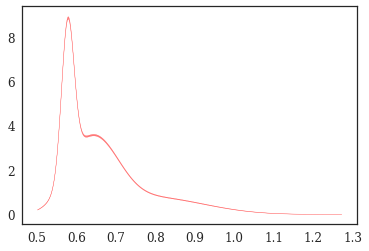

In [81]:
plt.fill_between(x, (z_x-np.sqrt(z_x))/norm, (z_x+np.sqrt(z_x))/norm, color='r', alpha=0.5)

In [84]:
np.sqrt(z_x)/z_x

array([0.03988827, 0.03858209, 0.0373326 , 0.03613663, 0.03499107,
       0.03389279, 0.03283865, 0.03182542, 0.03084974, 0.0299081 ,
       0.02899677, 0.02811179, 0.02724893, 0.02640374, 0.02557155,
       0.02474762, 0.02392723, 0.02310594, 0.02227985, 0.02144593,
       0.02060231, 0.01974865, 0.01888624, 0.01801816, 0.01714911,
       0.01628508, 0.01543299, 0.01460007, 0.01379335, 0.01301919,
       0.01228295, 0.01158873, 0.01093937, 0.01033648, 0.00978057,
       0.00927125, 0.00880745, 0.00838755, 0.00800964, 0.00767158,
       0.00737119, 0.00710629, 0.0068748 , 0.00667476, 0.00650438,
       0.00636204, 0.00624632, 0.00615595, 0.00608987, 0.00604717,
       0.0060271 , 0.00602901, 0.00605239, 0.00609676, 0.0061617 ,
       0.00624677, 0.00635146, 0.00647513, 0.00661697, 0.00677585,
       0.00695035, 0.00713858, 0.00733822, 0.00754642, 0.00775986,
       0.0079748 , 0.0081872 , 0.00839295, 0.00858806, 0.00876898,
       0.00893277, 0.00907733, 0.00920152, 0.00930512, 0.00938

In [72]:
z_x = np.sum((zz[:-1,:]+zz[1:,:])*(yy[1:,:]-yy[:-1,:])/2, axis=0)
z_ = np.sum((z_x[:-1]+z_x[1:])*(x[1:]-x[:-1]))/2
z_

3093.5788313467215

In [78]:
z_y = np.sum((zz[:,:-1]+zz[:,1:])*(xx[:,1:]-xx[:,:-1])/2, axis=1)
z_ = np.sum((z_y[:-1]+z_y[1:])*(y[1:]-y[:-1]))/2
z_

3093.578831346722

In [79]:
norm

4877.9349401083255

In [71]:
z_

3093.5788313467215

In [57]:
(xx[1:,:]-xx[:-1,:])

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

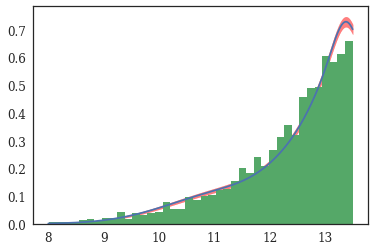

In [162]:
norm = np.sum(obs_pars[:,5])/2.2
plt.fill_between(y, (z_y - np.sqrt(z_y))/norm, (z_y + np.sqrt(z_y))/norm, color='r', alpha=0.5)
plt.plot(y, z_y/norm)

#bin_n, bin_edges =  np.histogram(survey1.Happ, bins=100)
#plt.bar(bin_edges[:-1], bin_n/(norm*(bin_edges[1]-bin_edges[0])), width=bin_edges[1]-bin_edges[0], fill=False)
_=plt.hist(survey1.Happ, bins=40, normed=True)

In [145]:
plt.bar?

In [144]:
len(bin_n), len(bin_edges)

(100, 101)

In [37]:
plt.hist?

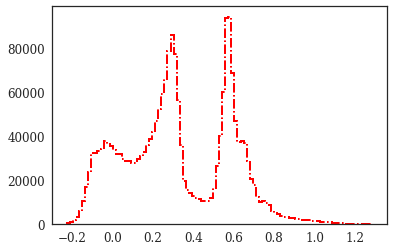

In [33]:
_=plt.hist(full1.Colour, label=label1, color='r', linestyle='-.', linewidth=2, histtype='step', bins=100)

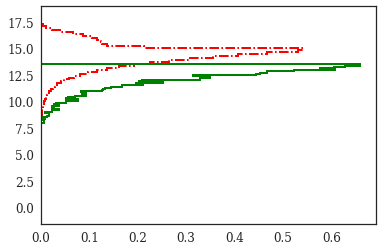

In [38]:
_=plt.hist(full1.Happ, color='r', linestyle='-.', linewidth=2, 
           histtype='step', bins=100, normed=True, orientation='horizontal')
_=plt.hist(survey1.Happ, color='g', linestyle='-', linewidth=2, 
           histtype='step', bins=50, normed=True, orientation='horizontal')